In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import glob
import os
from os import listdir
from os.path import join
import PIL
import time

from IPython import display

import random
from random import shuffle
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.utils as vutils
from torchvision import utils, models

!pip install nvidia-dali-cuda110

from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.plugin.pytorch import DALIGenericIterator, DALIClassificationIterator

device_id=None
device = torch.device("cuda")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.6/493.6 MB 2.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = "/content/drive/MyDrive/xray_bone_fracture/"

training_path = folder_path + "train/"
testing_path = folder_path + "val/"

In [4]:
def is_jpeg(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg"])

In [5]:
class ExternalInputIterator(object):

    def __init__(self, imageset_dir, labeled, batch_size, random_shuffle=False):
        self.images_dir = imageset_dir
        self.batch_size = batch_size
        self.labeled = labeled # True is images are labeled, False otherwise

        fractured_path = imageset_dir + "fractured/"
        self.fractured = np.array([join(fractured_path, "f_" + filename) for filename in sorted(listdir(fractured_path)) if is_jpeg(filename)])

        not_fractured_path = imageset_dir + "not_fractured/"
        self.not_fractured = np.array([join(not_fractured_path, "n_" + filename) for filename in sorted(listdir(not_fractured_path)) if is_jpeg(filename)])

        self.image_files = np.concatenate((self.fractured, self.not_fractured), axis = 0)

        self.label = {'f': 1, 'n': 0}

        if random_shuffle:
            ind = np.array(range(len(self.image_files)))
            shuffle(self.image_files)

    def __iter__(self):
        self.i = 0
        self.n = len(self.image_files)
        return self


    # Return a batch of (input, target) pairs
    def __next__(self):

        images = []
        labels = []

        for _ in range(self.batch_size):
            image_file = self.image_files[self.i]
            image_name = self.image_files[self.i].split('/')[-1]
            rem_file = "/".join(self.image_files[self.i].split('/')[:-1])
            if self.labeled:
                label = self.label[image_name[0]]
                labels.append(np.array([label], dtype = np.uint8))
            corrected_image_file = rem_file + "/" + image_name[2:]
            image = open(corrected_image_file, 'rb')
            images.append(np.frombuffer(image.read(), dtype = np.uint8))
            image.close()

            self.i = (self.i + 1) % self.n
        if self.labeled:
            return (images, labels)
        return images

    next = __next__

In [6]:
class XrayPipeline(Pipeline):
    '''
    Constructor arguments:
    - imageset_dir: directory containing the dataset
    - labeled = True
    - image_size = 128: length of the square that the images will be resized to
    - random_shuffle = False
    - batch_size = 64
    - num_threads = 1
    - device_id = 0
    '''

    def __init__(self, imageset_dir, labeled=True, image_size=128, random_shuffle=False, batch_size=64, num_threads=1, device_id=0):
        super(XrayPipeline, self).__init__(batch_size, num_threads, device_id, seed=12)
        eii = ExternalInputIterator(imageset_dir, labeled, batch_size, random_shuffle)
        self.iterator = iter(eii)
        self.num_inputs = len(eii.image_files)
        self.labeled = labeled

        # The source for the inputs
        self.input = ops.ExternalSource()
        self.input_label = ops.ExternalSource()

        self.decode = ops.ImageDecoder(device = 'mixed', output_type = types.RGB)

        # The rest of pre-processing is done on the GPU
        self.res = ops.Resize(device="gpu", resize_x=image_size, resize_y=image_size)
        self.norm = ops.CropMirrorNormalize(device='gpu', mean=0, std=255.0)


    # epoch_size = number of (profile, frontal) image pairs in the dataset
    def epoch_size(self, name = None):
        return self.num_inputs


    # Define the flow of the data loading and pre-processing
    def define_graph(self):

        if self.labeled:
            self.labels = self.input_label()
        self.jpegs = self.input()
        images = self.decode(self.jpegs)
        images = self.res(images)
        output = self.norm(images)
        if self.labeled:
            self.labels = self.input_label()
            return (output, self.labels)
        else:
            return output

    def iter_setup(self):
        if self.labeled:
            (images, labels) = self.iterator.next()
            self.feed_input(self.jpegs, images)
            self.feed_input(self.labels, labels)
        else:
            images = self.iterator.next()
            self.feed_input(self.jpegs, images)

/usr/local/lib/python3.10/dist-packages/nvidia/dali/ops/__init__.py:425: DeprecationWarning: WARNING: `image_decoder` is now deprecated. Use `decoders.image` instead.
In DALI 1.0 all decoders were moved into a dedicated :mod:`~nvidia.dali.fn.decoders`
submodule and renamed to follow a common pattern. This is a placeholder operator with identical
functionality to allow for backward compatibility.
  op_instances.append(_OperatorInstance(input_set, self, **kwargs))
/usr/local/lib/python3.10/dist-packages/nvidia/dali/plugin/base_iterator.py:191: Warning: Please set `reader_name` and don't set last_batch_padded and size manually whenever possible. This may lead, in some situations, to missing some samples or returning duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()
/usr/local/lib/python3.10/dist-packages/nvidia/dali/ops/__init__.py:425: DeprecationWarning: WARNING: `image_decoder` is now deprecated. Use `decoders.image` in

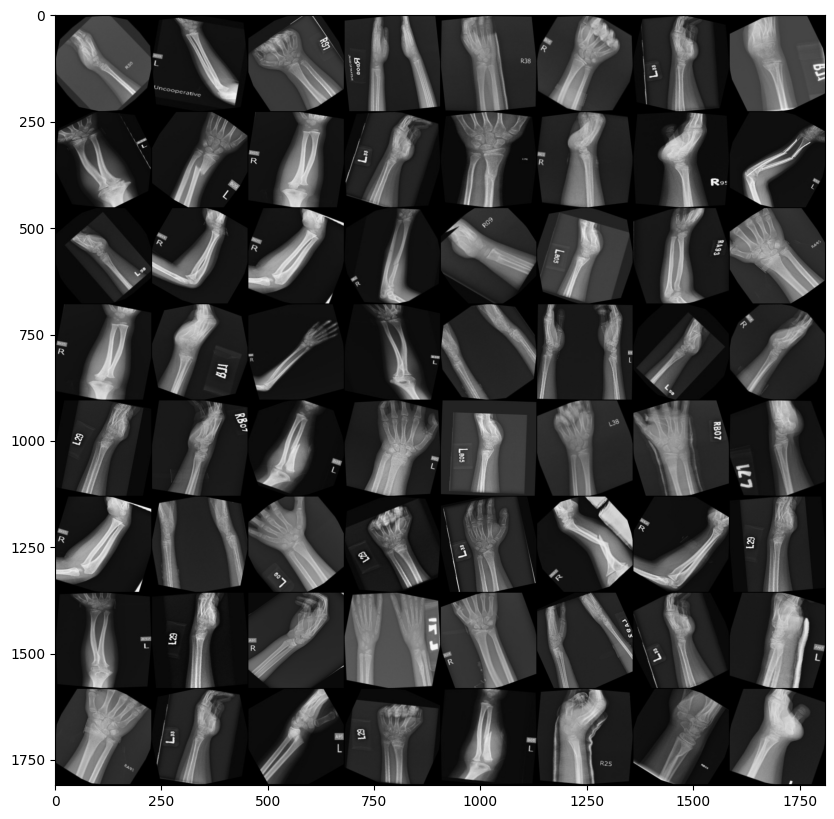

Labels:  tensor([[0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
         0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
         0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0]], dtype=torch.uint8)


In [7]:
batch_size = 64
epochs = 25

train_pipe = XrayPipeline(training_path, True, image_size=224, random_shuffle=True, batch_size=batch_size)
train_pipe.build()
train_loader = DALIClassificationIterator(train_pipe, train_pipe.epoch_size())


labeled_batch = next(iter(train_loader))
labeled_data = labeled_batch[0]['data'].type('torch.FloatTensor').to(device)
labels = labeled_batch[0]['label'].type(dtype=torch.long).squeeze().to(device)

gen_train_pipe = XrayPipeline(training_path, False, image_size=224, random_shuffle=True, batch_size=batch_size)
gen_train_pipe.build()
m_train = train_pipe.epoch_size()
gen_train_loader = DALIGenericIterator(gen_train_pipe, ['data'], m_train)


final_test_pipe = XrayPipeline(testing_path, True, image_size=224, random_shuffle=True, batch_size=100)
final_test_pipe.build()
final_test_loader = DALIClassificationIterator(final_test_pipe, final_test_pipe.epoch_size())

test_batch = next(iter(train_loader))
images_batch = test_batch[0]['data'].cpu()
labels_batch = test_batch[0]['label']
fig = plt.figure(figsize=(20,10))
grid = utils.make_grid(images_batch)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()
print('Labels: ', labels_batch.T)


In [8]:
def log_sum_exp(x, axis = 1):
    m = torch.max(x, dim = 1)[0]
    return m + torch.log(torch.sum(torch.exp(x - m.unsqueeze(1)), dim = axis))

# custom weights initialization called on the Generator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector
nz = 100
# Size of feature maps in generator
ngf = 64

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 7 x 7
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 14 x 14
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 28 x 28
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 4, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 112 x 112
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 224 x 224
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# A noise vector to be used for generating images at the end of each training epoch
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

netG = Generator().to(device)
netG.apply(weights_init)

classifier = models.efficientnet_b3()
#num_ftrs = classifier.fc.in_features
num_ftrs = classifier.classifier[1].in_features
classifier.fc = nn.Linear(num_ftrs, 2)
classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()


optimizerG = optim.Adam(netG.parameters(), lr=0.002, betas= (0.5, 0.999))
optimizerC = optim.Adam(classifier.parameters(), lr=0.002, betas= (0.5, 0.999))#, dampening=0, weight_decay=0.0001)

In [12]:
def test(model, device, test_loader, m_test, display = False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            data = batch[0]['data'].type('torch.FloatTensor').to(device)
            target = batch[0]['label'].type(dtype=torch.long).squeeze().to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= m_test

    if display == True:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, m_test,
        100. * correct / m_test))

    test_loader.reset()
    return test_loss, 100. * correct / m_test


Test set: Average loss: 0.0082, Accuracy: 409/600 (68%)




Test set: Average loss: 0.0255, Accuracy: 366/600 (61%)




Test set: Average loss: 0.0228, Accuracy: 292/600 (49%)




Test set: Average loss: 0.0192, Accuracy: 242/600 (40%)




Test set: Average loss: 0.0274, Accuracy: 265/600 (44%)




Test set: Average loss: 0.0090, Accuracy: 395/600 (66%)




Test set: Average loss: 0.0248, Accuracy: 317/600 (53%)




Test set: Average loss: 0.0081, Accuracy: 324/600 (54%)




Test set: Average loss: 0.0278, Accuracy: 338/600 (56%)




Test set: Average loss: 0.0258, Accuracy: 323/600 (54%)




Test set: Average loss: 0.0257, Accuracy: 345/600 (58%)




Test set: Average loss: 0.0342, Accuracy: 291/600 (48%)




Test set: Average loss: 0.0196, Accuracy: 271/600 (45%)




Test set: Average loss: 0.0585, Accuracy: 268/600 (45%)




Test set: Average loss: 0.1223, Accuracy: 242/600 (40%)




Test set: Average loss: 0.0984, Accuracy: 243/600 (40%)




Test set: Average loss: 0.1329, Accuracy: 246/600 (41%)




Test set: Average loss: 0.1407, Accuracy: 251/600 (42%)




Test set: Average loss: 0.0273, Accuracy: 283/600 (47%)




Test set: Average loss: 0.0424, Accuracy: 354/600 (59%)




Test set: Average loss: 0.0203, Accuracy: 356/600 (59%)




Test set: Average loss: 0.0167, Accuracy: 359/600 (60%)




Test set: Average loss: 0.0189, Accuracy: 366/600 (61%)




Test set: Average loss: 0.0218, Accuracy: 360/600 (60%)


Test set: Average loss: 0.0147, Accuracy: 349/600 (58%)



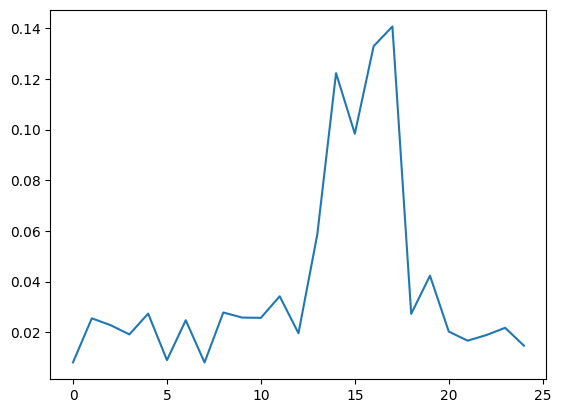

Best VAL test accuracy:  68.16666666666667 % after  0  training epochs

Best model on the test set: 

Test set: Average loss: 0.0082, Accuracy: 409/600 (68%)



(0.00817173143227895, 68.16666666666667)

In [13]:
test_losses = []
test_accuracies = []

best_model_wts = copy.deepcopy(classifier.state_dict())
best_acc = 0.0

for epoch in range(1, epochs + 1):

    for batch_idx, batch in enumerate(train_loader):

        # TRAIN THE DISCRIMINATOR (THE CLASSIFIER)
        classifier.train()
        optimizerC.zero_grad()

        # 1. on Unlabelled data
        data = batch[0]['data'].type('torch.FloatTensor').to(device)
        outputs = classifier(data)
        logz_unlabel = log_sum_exp(outputs)
        lossUL = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
        lossUL.backward()

        # 2. on the generated data

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        generated = (netG(noise)+1.0)/2.0
        outputs = classifier(generated.detach()) # detach() because we are not training G here
        logz_fake = log_sum_exp(outputs)
        lossD = 0.5*torch.mean(F.softplus(logz_fake))
        lossD.backward()

        # 3. on labeled data
        output = classifier(labeled_data)
        logz_label = log_sum_exp(output)
        prob_label = torch.gather(output, 1, labels.unsqueeze(1))
        labeled_loss = -torch.mean(prob_label) + torch.mean(logz_label)
        labeled_loss.backward()

        optimizerC.step()

        # TRAIN THE DISCRIMINATOR (THE CLASSIFIER)
        netG.train()
        optimizerG.zero_grad()

        outputs = classifier(generated)
        logz_unlabel = log_sum_exp(outputs)
        lossG = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
        lossG.backward()
        optimizerG.step()

    train_loader.reset()

    generated = (netG(fixed_noise)+1.0)/2.0
    vutils.save_image(generated.cpu().detach(), ('generated_%d.jpg' % epoch), normalize=True)

    test_loss, test_accuracy = test(classifier, device, final_test_loader, final_test_pipe.epoch_size(), True)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if test_accuracy > best_acc:
        best_acc = test_accuracy
        best_classifier_wts = copy.deepcopy(classifier.state_dict())

plt.plot(range(len(test_losses)), np.array(test_losses))
plt.show()

print('Best VAL test accuracy: ', np.max(np.array(test_accuracies)),
      '% after ', np.argmax(np.array(test_accuracies)), ' training epochs')

# load best model weights
classifier.load_state_dict(best_classifier_wts)

print("\nBest model on the test set: ")
test(classifier, device, final_test_loader, final_test_pipe.epoch_size(), True)

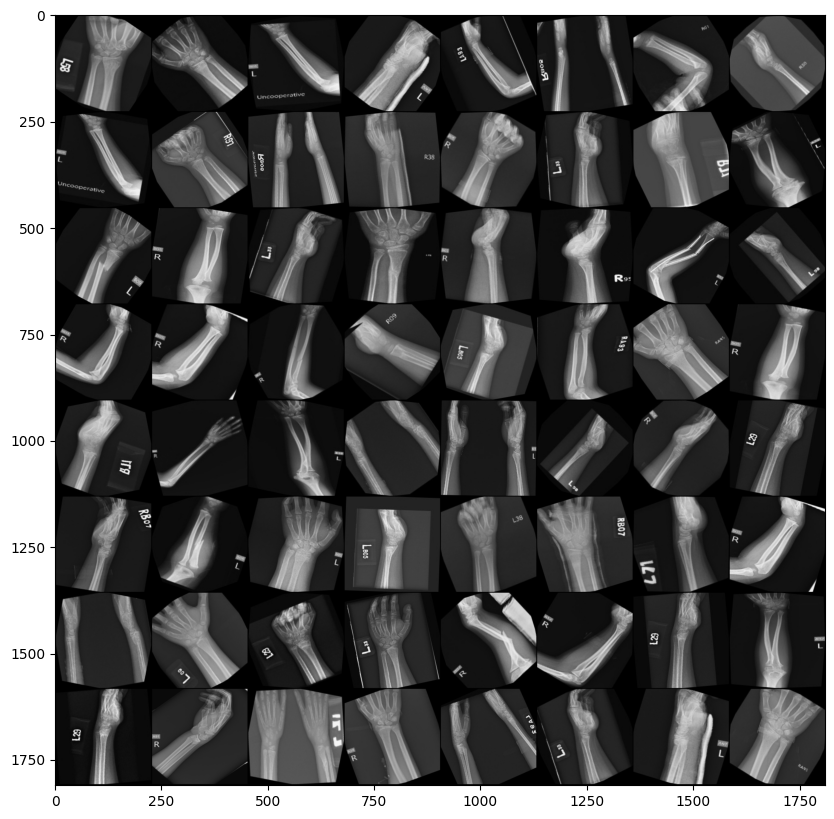

True Labels:  tensor([[1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
         0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
         1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)
Pred Labels:  tensor([[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
         1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]], device='cuda:0')


In [14]:
test_batch = next(iter(train_loader))
images_batch = test_batch[0]['data'].cpu()
labels_batch = test_batch[0]['label']

classifier.eval()
data = test_batch[0]['data'].type('torch.FloatTensor').to(device)
target = test_batch[0]['label'].type(dtype=torch.long).squeeze().to(device)
output = classifier(data)
pred_labels = output.argmax(dim=1, keepdim=True)


fig = plt.figure(figsize=(20,10))
grid = utils.make_grid(images_batch)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()
print('True Labels: ', labels_batch.T)
print('Pred Labels: ', pred_labels.T)
